# Chapter 3 Statistical Experiments and Significance Testing
### Imported libraries

In [44]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import random
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats import power

### Boxplot of session times for web pages A and B

In [3]:
session_times = pd.read_csv('web_page_data.csv')
session_times.shape

(36, 2)

Text(0.5, 0.98, '')

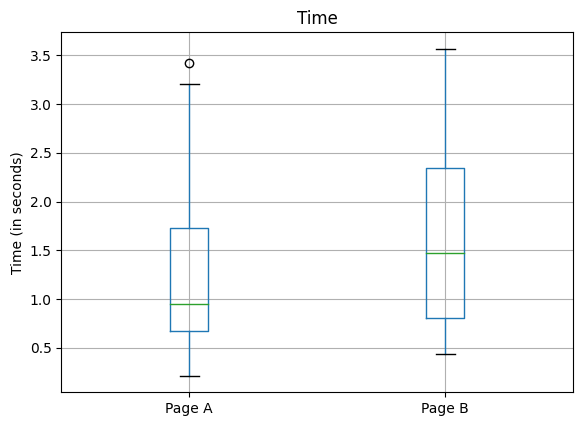

In [4]:
ax = session_times.boxplot(by='Page', column='Time')
ax.set_xlabel('')
ax.set_ylabel('Time (in seconds)')
plt.suptitle('')

### Mean of time

In [5]:
mean_a = session_times[session_times.Page == 'Page A'].Time.mean()
mean_b = session_times[session_times.Page == 'Page B'].Time.mean()
mean_b - mean_a

0.3566666666666669

### Permutation Test

In [12]:
def perm_fun(x, nA, nB):
    n = nA + nB
    idx_B = set(random.sample(range(n), nB))
    idx_A = set(range(n)) - idx_B
    return x.loc[list(idx_B)].mean() - x.loc[list(idx_A)].mean()

In [13]:
nA = session_times[session_times.Page == 'Page A'].shape[0]
nB = session_times[session_times.Page == 'Page B'].shape[0]
print(perm_fun(session_times.Time, nA, nB))

0.2995238095238095


Text(0, 0.5, 'Frequency')

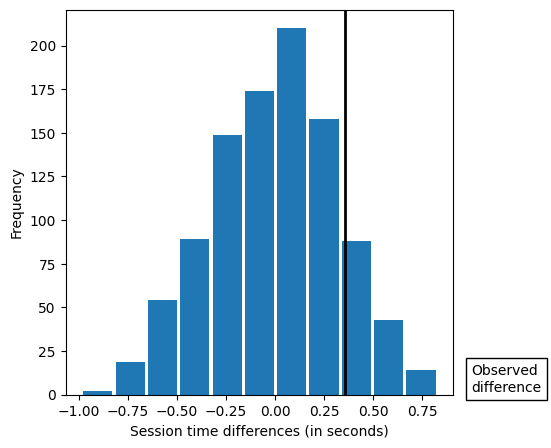

In [28]:
perm_diffs = [perm_fun(session_times.Time, nA, nB) for _ in range(1000)]

fig, ax = plt.subplots(figsize=(5, 5))
ax.hist(perm_diffs, bins=11, rwidth=0.9)
ax.axvline(x = mean_b - mean_a, color='black', lw=2)
ax.text(1, 2, 'Observed\ndifference', bbox={'facecolor':'white'})
ax.set_xlabel('Session time differences (in seconds)')
ax.set_ylabel('Frequency')

In [29]:
np.mean(perm_diffs > mean_b - mean_a)

0.121

### Statistical Significance

Observed difference: 0.0368%


Text(0, 0.5, 'Frequency')

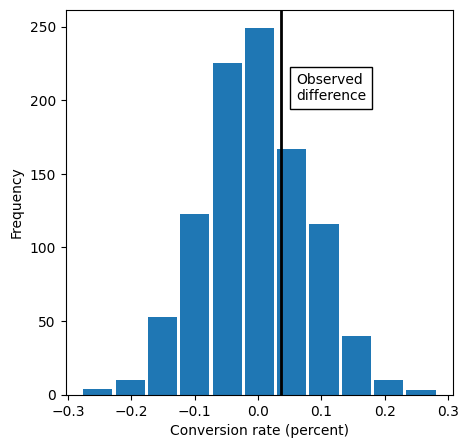

In [35]:
obs_pct_diff = 100*(200/23739 - 182/22588)
print(f'Observed difference: {obs_pct_diff:.4f}%')
conversion = [0]*45945
conversion.extend([1]*382)
conversion = pd.Series(conversion)

perm_diffs = [100 * perm_fun(conversion, 23739, 22588) for _ in range(1000)]

fig, ax = plt.subplots(figsize=(5,5))
ax.hist(perm_diffs, bins=11, rwidth=0.9)
ax.axvline(x=obs_pct_diff, color='black', lw=2)
ax.text(0.06,200, 'Observed\ndifference', bbox={'facecolor':'white'})
ax.set_xlabel('Conversion rate (percent)')
ax.set_ylabel('Frequency')

### p-Value

In [36]:
np.mean([diff > obs_pct_diff for diff in perm_diffs])

0.31

In [38]:
survivors = np.array([[200, 23739 - 200], [182, 22588 - 182]])
ch12, p_value, df, _ = stats.chi2_contingency(survivors)

In [39]:
print(f'p-value for single sided test: {p_value / 2:.4f}')

p-value for single sided test: 0.3498


### t-Tests

In [40]:
res = stats.ttest_ind(session_times[session_times.Page == 'Page A'].Time,
                      session_times[session_times.Page == 'Page B'].Time,
                      equal_var=False)
print(f'p-value for single sided test: {res.pvalue / 2:.4f}')

p-value for single sided test: 0.1408


### ANOVA

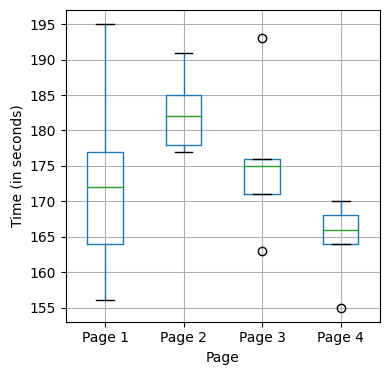

In [41]:
four_sessions = pd.read_csv('four_sessions.csv')

ax = four_sessions.boxplot(by='Page', column='Time',
                           figsize=(4, 4))
ax.set_xlabel('Page')
ax.set_ylabel('Time (in seconds)')
plt.suptitle('')
plt.title('')

plt.tight_layout()
plt.show()

In [42]:
observed_variance = four_sessions.groupby('Page').mean().var()[0]
print('Observed means:',four_sessions.groupby('Page').mean().values.ravel())
print('Variance:', observed_variance)

def perm_test(df):
    df = df.copy()
    df['True'] = np.random.permutation(df['Time'].values)
    return df.groupby('Page').mean().var()[0]

perm_variance = [perm_test(four_sessions) for _ in range(3000)]
print('Pr(Prob)', np.mean([var > observed_variance for var in perm_variance]))

Observed means: [172.8 182.6 175.6 164.6]
Variance: 55.426666666666655
Pr(Prob) 0.0


### F-Statistic

In [45]:
model = smf.ols('Time ~ Page', data= four_sessions).fit()

aov_table= sm.stats.anova_lm(model)
aov_table

,df,sum_sq,mean_sq,F,PR(>F)
Page,3.0,831.4,277.133333,2.739825,0.077586
Residual,16.0,1618.4,101.150000,NaN,NaN


### Chi-Square Test: A Resampling Approach

In [46]:
click_rate = pd.read_csv('click_rates.csv')
clicks = click_rate.pivot(index='Click', columns='Headline', values='Rate')
print(clicks)

Headline  Headline A  Headline B  Headline C
Click                                       
Click             14           8          12
No-click         986         992         988


In [48]:
box = [1] * 34
box.extend([0] * 2966)
random.shuffle(box)

def chi2(observed, expected):
    pearson_residuals = []
    for row, expect in zip(observed, expected):
        pearson_residuals.append([(observe - expect) ** 2 / expect for observe in row])
        #return sum of squares
        return np.sum(pearson_residuals)
    
expected_clicks = 34/3
expected_noclicks = 1000 - expected_clicks
expected = [34/3, 1000 - 34/3]
chi2observed = chi2(clicks.values, expected)

def perm_fun(box):
    sample_clicks = [sum(random.sample(box, 1000)),
                     sum(random.sample(box, 1000)),
                     sum(random.sample(box, 1000))]
    sample_noclicks = [1000 - n for n in sample_clicks]
    return chi2([sample_clicks, sample_noclicks], expected)

perm_chi2 = [perm_fun(box) for _ in range(2000)]
resampled_p_value = sum(perm_chi2 > chi2observed) / len(perm_chi2)
print(f'Observed chi2: {chi2observed:.4f}')
print(f'Resampled p-value: {resampled_p_value:.4f}')

Observed chi2: 1.6471
Resampled p-value: 0.4860


### Chi-Square Test: Statistical Theory

In [49]:
chisq, pvalue, df, expected = stats.chi2_contingency(clicks)
print(f'Observed chi2: {chi2observed:.4f}')
print(f'p-value: {pvalue:.4f}')

Observed chi2: 1.6471
p-value: 0.4348


### Sample Size

In [50]:
effect_size = sm.stats.proportion_effectsize(0.0121, 0.011)
analysis = sm.stats.TTestIndPower()
result = analysis.solve_power(effect_size=effect_size, alpha=0.05, power=0.8, alternative='larger')
print('Sample Size: %.3f' % result)

Sample Size: 116602.393
